In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import ensemble
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score



'''TrainingSet'''
DataSet_A=pd.read_csv('TrainingSet_0.csv').iloc[:,2:]
DataSet_B=pd.read_csv("TrainingSet_new.csv").iloc[:,2:]
DataSet_A.rename({'GB':'level'},axis=1,inplace=True)
DataSet_B.rename({'GB':'level'},axis=1,inplace=True)


'''TestingSet'''
TestingSet=pd.read_csv("TestingSet_0.csv").iloc[:,2:]
TestingSet.rename({'GB':'level'},axis=1,inplace=True)

X_test=TestingSet.iloc[:,:-1].values
Y_test=TestingSet.iloc[:,-1].values


OS_1=pd.read_csv('TrainingSet_new.csv').iloc[:,1:]

OS_2=pd.read_csv('OS.csv').iloc[:,1:]

Data=pd.concat([OS_1,OS_2])

T2_X=Data.iloc[:,1:-1].values
T2_Y=Data.iloc[:,-1:].values

## For Data Setting 4~6

T2_X_2=OS_1.iloc[:,1:-1].values
T2_Y_2=OS_1.iloc[:,-1:].values

## For Data Setting 10~12

Negatives=OS_1[OS_1.GB==0].iloc[:,1:]

D_10=pd.read_csv("DataSetting_10.csv").iloc[:,1:]
D_10=D_10[D_10.GB==1]
Test_10=pd.concat([Negatives,D_10])
Test_10.to_csv('Test_10.csv')

D_11=pd.read_csv("DataSetting_11.csv").iloc[:,1:]
D_11=D_11[D_11.GB==1]
Test_11=pd.concat([Negatives,D_11])
Test_11.to_csv('Test_11.csv')

D_12=pd.read_csv("DataSetting_12.csv").iloc[:,1:]
D_12=D_12[D_12.GB==1]
Test_12=pd.concat([Negatives,D_12])
Test_12.to_csv('Test_12.csv')

##將每個種類放入字典中
D=pd.read_csv('Bad_Types.csv').iloc[:,1:]
Bad_Types={D.cb[i]:i for i in range (len(D))}

In [30]:
'''二元資料集的平衡程度'''
def Balance_Ratio(TrainingSet):
    r=len(TrainingSet[TrainingSet.level==1])/len(TrainingSet[TrainingSet.level==0])
    return r

'''新的 TrainingSet '''
def training(TrainingSet):
    
    global X_train, Y_train
    
    X_train=TrainingSet.iloc[:,:-1].values
    Y_train=TrainingSet.iloc[:,-1].values
    
'''Classifier''' 

## 矩陣 左下: 真正陽性 未被找到 , 右下: 真正陽性 且 被找到  / infor=0 代表只顯示被預測出的 BAD 類型
def cf_matrix(X_train,X_test,Y_train,Y_test,n_E=100,LR=0.7,r=0,infor=0):
    
    global Y,Bad,check,I,ar
    check=0
    
    tree = ensemble.AdaBoostClassifier(DecisionTreeClassifier(),n_estimators=n_E, learning_rate=LR,random_state=r)
    tree_fit = tree.fit(X_train,Y_train)
    Y_score=tree.predict(X_test)
    Y_score=pd.DataFrame(Y_score)
    Y_true=pd.DataFrame(Y_test)
    Y=pd.concat([Y_true,Y_score],axis=1)
    Y.columns=["class_true","class_pd"]
    s = range(2)
    I = np.zeros([2,2])
    
    for i,x in zip(s,range(2)):
        for j,y in zip(s,range(2)):
            I[x,y]=len(Y[(Y.class_true==i)&(Y.class_pd==j)])
    
    num_pd=0
    for i in range(2):
        num_pd=num_pd+I[i,-1]

    if num_pd!=0:
        precision=I[-1,-1]/num_pd
    else:
        precision=0
    
    if sum(I[-1])!=0:
        recall=I[-1,-1]/sum(I[-1])
    else:
        recall=0
    
    I=I.astype(int)
    

    
    '''hind'''
    #print(I,'\n')       
    
    if infor==0:
        
        ar=(I[0][1]+I[1][1])/len(Y_test)
        #print('Aging_Rate:',ar)
        
        TP=Y[(Y.class_true==1)&(Y.class_pd==1)].index
        Bad=[]
        for j in range(len(TP)):

            Index=TP[j]
            Key=X_test[Index]
            Key=pd.DataFrame(Key).T.apply(lambda x:'_'.join(x.astype(str)),axis=1)
            Bad=np.append(Bad,Bad_Types[Key[0]])
            Bad.sort()
            
        print('Types of Bad :',Bad)   
    
    elif infor==1:
        FN=Y[(Y.class_true==1)&(Y.class_pd==0)].index
        Bad_miss=[]
        for j in range(len(FN)):

            Index=FN[j]
            Key=X_test[Index]
            Key=pd.DataFrame(Key).T.apply(lambda x:'_'.join(x.astype(str)),axis=1)
            Bad_miss=np.append(Bad_miss,Bad_Types[Key[0]])
            Bad_miss.sort()
        
        print('Types of Bad not found:',Bad_miss)
        
    #print("Precision,Recall:",precision,',',recall,'\n')
        
    return precision, recall    

def AUC(x,y):
    area=0
    left=x[0]*y[0]
    right=(1-x[len(x)-1])*y[len(x)-1]
    
    for i in range(1,len(x)):
        
        wide=x[i]-x[i-1]
        area=area+wide*((y[i-1]+y[i])/2)
        
    area=left+area+right  
    return area

'''回歸樹分類器'''

def Ada_Reg_clf(X_train,X_test,Y_train,Y_test,n_E=100,LR=0.7,r=0,infor=1,prob=0.5):
    
    global Y,Predict_df,Y_new,Bad,Threshold,auc,P,R,Aging_Rate
    r_tree = ensemble.AdaBoostRegressor(DecisionTreeRegressor(),n_estimators=n_E, learning_rate=LR,random_state=r)
    r_tree_fit = r_tree.fit(X_train,Y_train)
    Y_score=r_tree.predict(X_test)
    Y_score=pd.DataFrame(Y_score)
    Y_true=pd.DataFrame(Y_test)
    Y=pd.concat([Y_true,Y_score],axis=1)
    Y.columns=["class_true","class_pd"]
    
    df=Y.copy()
    df=df.sort_values(['class_pd','class_true'],ascending=[False,True])
    TP=df[df.class_true==1].index
    Bad=[]
    
    
    if infor==1:
        
        for j in range(len(TP)):

            Index=TP[j]
            Key=X_test[Index]
            Key=pd.DataFrame(Key).T.apply(lambda x:'_'.join(x.astype(str)),axis=1)
            Bad=np.append(Bad,Bad_Types.get(Key[0]))


        print('Types of Bad :',Bad)
    
    
    Y_new=Y.sort_values(['class_pd','class_true'],ascending=[False,True]).reset_index(drop=True)
    
    
    Predict_df=Y_new.copy()
    Y_new_1=Y_new[Y_new.class_true==1]
    
    #print('Search amount :',Y_new_1.index.values,'\n')
    
    Y_new.loc[Y_new.class_true!=1,'class_true']=0
    Y_new['S']=Y_new.groupby('class_pd')['class_true'].transform('sum')
    Y_new['C']=Y_new.groupby('class_pd')['class_true'].transform('count')
    Y_new=Y_new.drop_duplicates(subset=['class_pd']).reset_index(drop=True)
    
    Y_new['cu_count']=Y_new['C'].cumsum()
    Y_new['cu_sum']=Y_new['S'].cumsum()
    Y_new['Precision']=Y_new['cu_sum']/Y_new['cu_count']
    Y_new['Recall']=Y_new['cu_sum']/Y_test.sum()
    
    B=np.arange(1,Y_test.sum()+1)/Y_test.sum()
    I=Predict_df[Predict_df.class_true==1].index
    All=(I/len(Predict_df)).values
    
    ## Area 為藍線左上的面積 越大越好
    Area=B[0]*All[0]/2
    
    
    for i in range(len(All)-1):
        part=(B[i]+B[i+1])*(All[i+1]-All[i])/2
        Area=Area+part
        
    
    Area=Area+1-All[len(All)-1]

    ## Check if Area > 0.5
    #if Area > 0.5:
    #    print('OK!\n')
    #else: print('Bad!\n')
        
    Threshold=Y_new[Y_new.class_pd>=prob].tail(1)
    
    
    if len(Y_new[(Y_new.class_pd>=0.5)])!=0:
        Aging_Rate=Y_new[Y_new.class_pd>=prob].tail(1).cu_count.values/Y_new.tail(1).cu_count.values
        amount=int(Y_new[(Y_new.class_pd>=prob)].tail(1).iat[0,5])    
        Bad_Detect=np.sort(Bad[0:amount])
    else:
        Bad_Detect=[]
        Aging_Rate=0
    
    
    if infor==1:
        print('Aging_Rate_prob=%s :'%prob,Aging_Rate)
        print('Bad Detection when threshold=%s :'%prob,Bad_Detect)
    
    print('PR curve :')
    Y_new=Y_new[Y_new.Precision!=0]
    plt.plot(Y_new['Recall'],Y_new['Precision'])
    plt.plot(Y_new['Recall'],Y_new['Precision'],'r.')
    plt.plot(Threshold['Recall'],Threshold['Precision'],'go',markersize=10)
    P=Threshold.Precision.values
    R=Threshold.Recall.values
    print('Precision & Recall:',P,R)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.show()
    auc=AUC(Y_new['Recall'].values,Y_new['Precision'].values)
    
    print('AUC: ',auc,'\n')

    return P,R
    
## 可以更改 Beta 值    
def F_score(P,R,beta=1):
    if (P!=0)&(R!=0):
        f=((1+beta*beta)*(P*R))/((beta*beta*P)+R)
    else: f=0
    return f 

## 可以決定是否運算 train_score
def CLF_result(DataSetting,n_E,LR,train_score_show=1,J=0,balance_show=0):
    
    global PR_sub,Hard,Count_sub
    PR_sub=[]
    Count_sub=[]
    
    if balance_show==1:
        print('Balance ratio:',Balance_Ratio(DataSetting),'\n')
    training(DataSetting)
    if train_score_show==1:
        
        #print('Train_1 :')
        P,R=cf_matrix(X_train,X_train,Y_train,Y_train,n_E,LR,infor=2)
        PR_sub=np.append(PR_sub,(P,R))
        GT_0=I[0][0]+I[0][1]
        Train_OK=GT_0
        FP=I[0][1]
        Train_NG=I[1][0]+I[1][1]
        #print('Trained_OK:',Train_OK)
        #print('Trained_NG:',Train_NG)
        
        #print('Train_2 :')
        
        if J<=3:
            P,R=cf_matrix(X_train,T2_X,Y_train,T2_Y,n_E,LR,infor=2)
        elif J<=6:
            P,R=cf_matrix(X_train,T2_X_2,Y_train,T2_Y_2,n_E,LR,infor=2)
        elif J<=9:
            P,R=cf_matrix(X_train,T2_X,Y_train,T2_Y,n_E,LR,infor=2)
        elif J<=12:
            Test=pd.read_csv("Test_%s.csv" %J).iloc[:,1:]
            Test_X=Test.iloc[:,:-1].values
            Test_Y=Test.iloc[:,-1:].values
            P,R=cf_matrix(X_train,Test_X,Y_train,Test_Y,n_E,LR,infor=2)
            
        PR_sub=np.append(PR_sub,(P,R))
        GT_0_2=I[0][0]+I[0][1]
        FP_2=I[0][1]
        Hard=(FP_2-FP)/(GT_0_2-GT_0)
        Filt_OK=GT_0_2-GT_0
        #print('Filtered_OK',Filt_OK)
        #print("Hardness:",Hard)
    
    #print('Test : ')
    P,R=cf_matrix(X_train,X_test,Y_train,Y_test,n_E,LR)
    PR_sub=np.append(PR_sub,(P,R))
    #PR_sub=np.around(PR_sub, decimals=4)
    Aging_rate=sum(I[:,1])/sum(sum(I))
    Count_sub=np.append(Count_sub,(Train_OK,Train_NG,Filt_OK,Aging_rate))
    
    
    #F=F_score(P,R,beta=3)*100
    
    #print('F_score:',F,'%')

## 先建一個 BAD名稱為 cols 的 df 
def compare_diff_datasetting(TestingSet):

    df=pd.DataFrame()
    origin_B=TestingSet[(TestingSet.level==1)].index
    Bad=[]
    for j in range(len(origin_B)):

        Index=origin_B[j]
        Key=X_test[Index]
        Key=pd.DataFrame(Key).T.apply(lambda x:'_'.join(x.astype(str)),axis=1)
        Bad=np.append(Bad,Bad_Types[Key[0]])
        Bad.sort()
    
    df = pd.DataFrame(columns=Bad)
    return df

def Bad_Type_Plot(df):
    
    df.replace(True,1,inplace=True)
    df.replace(False,0,inplace=True)
    plt.pcolor(df,cmap='RdPu')
    plt.title("Bad detection by different DataSetting")
    plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns.astype(int))
    plt.xlabel("ID",size=12)
    plt.ylabel("DataSetting",size=12)
    plt.show()

## 一次性完成 AdaBoost (參數為 執行幾個DataSetting)
def S4_AdaBoost(num_DataSetting,n_E=100,LR=0.6):
    
    global df_Count,df_PR,H,df_PR_new,cv_B
    PR=[]
    Count=[]
    H=[]
    df=compare_diff_datasetting(TestingSet)
    df_B=compare_diff_datasetting(TestingSet)
    Bad_Set=[]
    C=[]
    print('Testing_Bad_types\n',df.columns.values)

    for i in range(num_DataSetting):

        j=i+1
        DataSetting=pd.read_csv("DataSetting_%s.csv" %j).iloc[:,1:]
        DataSetting.rename({'GB':'level'},axis=1,inplace=True)
        print('\nModel',j,':\n')
        CLF_result(DataSetting,n_E,LR,J=j)
        PR=np.append(PR,PR_sub)
        Count=np.append(Count,Count_sub)
        H=np.append(H,Hard)
        Bad_Set=np.append(Bad_Set,Bad)
        match= np.in1d(df.columns.values,Bad)
        C=np.append(C,check)
        df.loc[j]=match
        
        count_B=Counter(Bad_Set.astype(int))
        myList = list(count_B.values())
        myInt = 12
        newList = [x / myInt for x in myList]
        newList=pd.DataFrame(newList).T
        newList.columns=count_B.keys()
        df_B=pd.concat([df_B,newList])
        
                
    cv_B=df_B.tail(1)
        
    df['check']=C
    print('\nTotal_Bad :',len(Bad_Set))
    Bad_Type_Plot(df.iloc[:,:-1])
    
    '''
    print('OK_DataSetting')
    df_OK=df[df.check==1].copy()
    Bad_Type_Plot(df_OK.iloc[:,:-1])
    
    '''
    
    Count.resize((int(Count.size/4),4),refcheck=False)
    df_Count=pd.DataFrame(Count)
    df_Count.columns=['Train_OK','Train_NG','Filt_OK','Aging_rate']
    df_Count[['Train_OK','Train_NG','Filt_OK']]=df_Count[['Train_OK','Train_NG','Filt_OK']].astype(int)
    PR.resize((int(PR.size/6),6),refcheck=False)
    df_PR=pd.DataFrame(PR)
    df_PR.columns=['p1','r1','p2','r2','p3','r3']
    df_PR_new=df_PR.copy()
    
    df_PR['T1']=df_PR[['p1','r1']].astype(str).agg(' / '.join, axis=1)
    df_PR['T2']=df_PR[['p2','r2']].astype(str).agg(' / '.join, axis=1)
    df_PR['T3']=df_PR[['p3','r3']].astype(str).agg(' / '.join, axis=1)
    df_PR=df_PR.iloc[:,-3:]
    H=pd.DataFrame(H)
    
    df_PR=pd.concat([df_Count,df_PR,H],axis=1)
    df_PR.rename(columns={0:'SRS'},inplace=True)
    df_PR['DataSetting']=np.arange(1,1+num_DataSetting)
    
    df_PR_new=pd.concat([df_Count[['Aging_rate']],df_PR_new,H],axis=1)
    df_PR_new.rename(columns={0:'SRS'},inplace=True)
    df_PR_new['DataSetting']=np.arange(1,1+num_DataSetting)
    
    df_PR_new=pd.concat([df_PR_new,cv_B],axis=1)

    
    df_PR=df_PR[['DataSetting','Train_OK','Train_NG','Filt_OK','Aging_rate','T1','T2','T3','SRS']]
    
    
## INPUT 連續
def S4_AdaRegressor(num_DataSetting,n_E=100,LR=0.7,r=0.5,random=0,probability=0.5):
    
    global Score
    P_sub_1=[]
    R_sub_1=[]
    P_sub_2=[]
    R_sub_2=[]
    P_sub_3=[]
    R_sub_3=[]
    A_Rate=[]
    AUC_set=[]
    Hard=[]
    
    df=compare_diff_datasetting(TestingSet)
    
    for i in range(num_DataSetting):

        j=i+1
        DataSetting=pd.read_csv("DataSetting_%s_reg.csv" %j).iloc[:,1:].drop('GB',axis=1)
        DataSetting.rename({'New_GB':'GB'},axis=1,inplace=True)
        print('Model',j,':\n')
        training(DataSetting)
        print('Train_1 :')
        Y_test_new=pd.read_csv("DataSetting_%s_reg.csv" %j).GB.values
        Ada_Reg_clf(X_train,X_train,Y_train,Y_test_new,n_E=n_E,LR=LR,r=random,infor=2,prob=probability)
        
        Y_new['Aging_Rate']=Y_new['cu_count']/(Y_new['cu_count'].max())
        Table_Train=Y_new[['class_pd','Precision','Recall','Aging_Rate']]
        
        P_sub_1=np.append(P_sub_1,P)
        R_sub_1=np.append(R_sub_1,R)
        
        
        cu_count_1=len(Y_train[Y_train!=1])
        Negative_1=Threshold.cu_count.values-Threshold.cu_sum.values
        
        print('Train_2 :')
        
    
        if j<=3:
            Ada_Reg_clf(X_train,T2_X,Y_train,T2_Y,n_E=n_E,LR=LR,r=random,infor=2,prob=probability)
            P_sub_2=np.append(P_sub_2,P)
            R_sub_2=np.append(R_sub_2,R)
           
            cu_count_2=len(T2_Y[T2_Y!=1])
        elif j<=6:
            Ada_Reg_clf(X_train,T2_X_2,Y_train,T2_Y_2,n_E=n_E,LR=LR,r=random,infor=2,prob=probability)
            P_sub_2=np.append(P_sub_2,P)
            R_sub_2=np.append(R_sub_2,R)
         
            cu_count_2=len(T2_Y_2[T2_Y_2!=1])
        elif j<=9:
            Ada_Reg_clf(X_train,T2_X,Y_train,T2_Y,n_E=n_E,LR=LR,r=random,infor=2,prob=probability)
            P_sub_2=np.append(P_sub_2,P)
            R_sub_2=np.append(R_sub_2,R)
          
            cu_count_2=len(T2_Y[T2_Y!=1])
        elif j<=12:
            Test=pd.read_csv("Test_%s.csv" %j).iloc[:,1:]
            Test_X=Test.iloc[:,:-1].values
            Test_Y=Test.iloc[:,-1:].values
            Ada_Reg_clf(X_train,Test_X,Y_train,Test_Y,n_E=n_E,LR=LR,r=random,infor=2,prob=probability)
            P_sub_2=np.append(P_sub_2,P)
            R_sub_2=np.append(R_sub_2,R)
         
            cu_count_2=len(Test_Y[Test_Y!=1])
        
        Negative_2=Threshold.cu_count.values-Threshold.cu_sum.values
        
        H=(Negative_2-Negative_1)/(cu_count_2-cu_count_1)
        print('H:',H,'\n')
        Hard=np.append(Hard,H)
       
        print('Test:')
        Ada_Reg_clf(X_train,X_test,Y_train,Y_test,n_E=n_E,LR=LR,r=random,infor=1,prob=probability)
        
        Y_new['Aging_Rate']=Y_new['cu_count']/(Y_new['cu_count'].max())
        Table_Test=Y_new[['class_pd','Precision','Recall','Aging_Rate']]
        
        Table=pd.concat([Table_Train,Table_Test],axis=1)
        Table.to_csv('DS_reg_%s.csv' %j)
        
        P_sub_3=np.append(P_sub_3,P)
        R_sub_3=np.append(R_sub_3,R)
        AUC_set=np.append(AUC_set,auc)
        A_Rate=np.append(A_Rate,Aging_Rate)
        
        ## Bad Detection 圖形在r的抽檢比例內
        ratio=r
        Bad_count=Y_new[Y_new.cu_count<=len(TestingSet)*ratio]['S'].sum()
        B=Bad[:Bad_count]
        match= np.in1d(df.columns.values,B)
        df.loc[j]=match
        
    p_1=pd.DataFrame(P_sub_1)
    r_1=pd.DataFrame(R_sub_1)
    p_2=pd.DataFrame(P_sub_2)
    r_2=pd.DataFrame(R_sub_2)
    p_3=pd.DataFrame(P_sub_3)
    r_3=pd.DataFrame(R_sub_3)
    AR=pd.DataFrame(A_Rate) 
    a=pd.DataFrame(AUC_set)
    h=pd.DataFrame(Hard)
    Score=pd.concat([p_1,r_1,p_2,r_2,p_3,r_3,AR,a,h],axis=1)
    Score.columns=['p1','r1','p2','r2','p3','r3','Aging_rate','AUC',"SRS"]
    Score.insert(0,'DataSetting',np.arange(1,1+num_DataSetting))
    Bad_Type_Plot(df)
    print(Score,'\n')
    return Score

## INPUT 非連續
def S4_AdaRegressor_Dis(num_DataSetting,n_E=100,LR=0.6,r=0.5,random=0,probability=0.5):
    

    global Score
    P_sub_1=[]
    R_sub_1=[]
    P_sub_2=[]
    R_sub_2=[]
    P_sub_3=[]
    R_sub_3=[]
    A_Rate=[]
    AUC_set=[]
    Hard=[]
    df=compare_diff_datasetting(TestingSet)
    
    for i in range(num_DataSetting):

        j=i+1
        DataSetting=pd.read_csv("DataSetting_%s.csv" %j).iloc[:,1:]
        DataSetting.rename({'GB':'level'},axis=1,inplace=True)
        print('Model',j,':\n')
        training(DataSetting)
        print('Train_1 :')
        Ada_Reg_clf(X_train,X_train,Y_train,Y_train,n_E=n_E,LR=LR,r=random,infor=2,prob=probability)
        P_sub_1=np.append(P_sub_1,P)
        R_sub_1=np.append(R_sub_1,R)
        cu_count_1=len(Y_train[Y_train<1])
        Negative_1=Threshold.cu_count.values-Threshold.cu_sum.values
        
        print('Train_2 :')
        
        if j<=3:
            Ada_Reg_clf(X_train,T2_X,Y_train,T2_Y,n_E=n_E,LR=LR,r=random,infor=2,prob=probability)
            P_sub_2=np.append(P_sub_2,P)
            R_sub_2=np.append(R_sub_2,R)
            cu_count_2=len(T2_Y[T2_Y!=1])
        elif j<=6:
            Ada_Reg_clf(X_train,T2_X_2,Y_train,T2_Y_2,n_E=n_E,LR=LR,r=random,infor=2,prob=probability)
            P_sub_2=np.append(P_sub_2,P)
            R_sub_2=np.append(R_sub_2,R)
            cu_count_2=len(T2_Y_2[T2_Y_2!=1])
        elif j<=9:
            Ada_Reg_clf(X_train,T2_X,Y_train,T2_Y,n_E=n_E,LR=LR,r=random,infor=2,prob=probability)
            P_sub_2=np.append(P_sub_2,P)
            R_sub_2=np.append(R_sub_2,R)
            cu_count_2=len(T2_Y[T2_Y!=1])
        elif j<=12:
            Test=pd.read_csv("Test_%s.csv" %j).iloc[:,1:]
            Test_X=Test.iloc[:,:-1].values
            Test_Y=Test.iloc[:,-1:].values
            Ada_Reg_clf(X_train,Test_X,Y_train,Test_Y,n_E=n_E,LR=LR,r=random,infor=2,prob=probability)
            P_sub_2=np.append(P_sub_2,P)
            R_sub_2=np.append(R_sub_2,R)
            cu_count_2=len(Test_Y[Test_Y<1])
        
            
        Negative_2=Threshold.cu_count.values-Threshold.cu_sum.values
        
        H=(Negative_2-Negative_1)/(cu_count_2-cu_count_1)
        Hard=np.append(Hard,H)
        print('H:',H,'\n')
            
            
        print('Test:')
        Ada_Reg_clf(X_train,X_test,Y_train,Y_test,n_E=n_E,LR=LR,r=random,infor=1,prob=probability)
        P_sub_3=np.append(P_sub_3,P)
        R_sub_3=np.append(R_sub_3,R)
        AUC_set=np.append(AUC_set,auc)
        A_Rate=np.append(A_Rate,Aging_Rate)
        
        ratio=r
        Bad_count=Y_new[Y_new.cu_count<=len(TestingSet)*ratio]['S'].sum()
        B=Bad[:Bad_count]
        match= np.in1d(df.columns.values,B)
        df.loc[j]=match
        
    
    p_1=pd.DataFrame(P_sub_1)
    r_1=pd.DataFrame(R_sub_1)
    p_2=pd.DataFrame(P_sub_2)
    r_2=pd.DataFrame(R_sub_2)
    p_3=pd.DataFrame(P_sub_3)
    r_3=pd.DataFrame(R_sub_3)
    AR=pd.DataFrame(A_Rate)
    a=pd.DataFrame(AUC_set)
    h=pd.DataFrame(Hard)
    Score=pd.concat([p_1,r_1,p_2,r_2,p_3,r_3,AR,a,h],axis=1)
    Score.columns=['p1','r1','p2','r2','p3','r3','Aging_rate','AUC',"SRS"]
    Score.insert(0,'DataSetting',np.arange(1,1+num_DataSetting))
    Bad_Type_Plot(df)
    print(Score,'\n')
    return Score

def color_high_red(val):
    
    if val>0.5:
        color = 'red' if val > 0.7 else 'orange'
    else: color = 'black'
    
    return 'color: %s' % color

def color_high_blue(val):

    color = 'blue' if val > 1 else 'black'
    return 'color: %s' % color

def color(DF):
    d=dict.fromkeys(DF.select_dtypes('float').columns, '{:.4f}')
    return DF.style.applymap(color_high_red,subset=['r3']).applymap(color_high_blue,subset=['Eff']).format(d)

    
def Line_Chart(DF,s='AdaBoost\n',save='AdaBoost_a_03.jpg'):
    
    x=DF.DataSetting.values
    y1=DF.Aging_rate.values
    y2=DF.r3.values
    y3=DF.p3.values
    
    fig,ax1 = plt.subplots(figsize=(15,8))
    ax2 = ax1.twinx()
    plt.title(s)
    ax1.plot(x,y1,'b--')
    ax1.plot(x,y2,'r-')
    ax2.plot(x,y3,'g--')
    
    ax1.set_xlabel('\nDataSetting',fontsize=12)
    ax1.set_ylabel('Recall and Aging rate',color='r')
    ax2.set_ylabel('Precision',color='g')

    plt.savefig(save)
    plt.show()
    
def Line_Chart_reg(DF,s='AdaBoost\n',save='AdaBoost_a_03.jpg'):
    
    x=DF.DataSetting.values
    y1=DF.Aging_rate.values
    y2=DF.r3.values
    y3=DF.p3.values
    
    fig,ax1 = plt.subplots(figsize=(15,8))
    ax2 = ax1.twinx()
    plt.title(s)
    plt.xticks(range(1,13,1))
    ax1.plot(x,y1,'b--')
    ax1.plot(x,y2,'r-')
    ax2.plot(x,y3,'g--')
    
    ax1.set_xlabel('\nDataSetting',fontsize=12)
    ax1.set_ylabel('Recall and Aging rate',color='r')
    ax2.set_ylabel('Precision',color='g')

    plt.savefig(save)
    plt.show()

Types of Bad : []
Types of Bad : []
Testing_Bad_types
 [ 0.  8. 13. 14. 16. 20. 30. 47. 60.]

Model 1 :

Types of Bad : [16.]

Model 2 :

Types of Bad : [16.]

Model 3 :

Types of Bad : [ 8. 14. 16. 60.]

Model 4 :

Types of Bad : [16.]

Model 5 :

Types of Bad : [ 0. 16. 20. 47.]

Model 6 :

Types of Bad : [16. 20.]

Model 7 :

Types of Bad : []

Model 8 :

Types of Bad : [ 0. 16. 20. 47.]

Model 9 :

Types of Bad : [14. 16. 60.]

Model 10 :

Types of Bad : [16.]

Model 11 :

Types of Bad : [ 0. 16. 20. 47.]

Model 12 :

Types of Bad : [13. 14. 16. 60.]

Total_Bad : 29


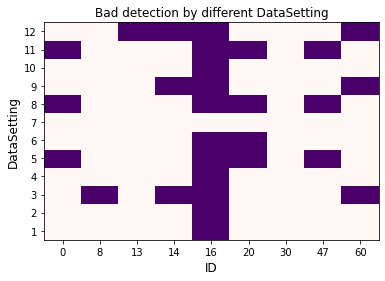


執行時間：9.188431 秒 



,DataSetting,BR,Train_OK,Train_NG,Filt_OK,p1,r1,p2,r2,p3,r3,Aging_rate,Eff,SRS,0.0,8.0,13.0,14.0,16.0,20.0,30.0,47.0,60.0
DataSettingA,A,nan,nan,nan,nan,nan,nan,nan,nan,0.0000,0.0000,0.0001,0.0000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
DataSettingB,B,nan,nan,nan,nan,nan,nan,nan,nan,0.0000,0.0000,0.0234,0.0000,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
0,1,0.3000,1100.0000,330.0000,13436.0000,1.0000,0.9818,0.8804,0.9818,0.0026,0.1111,0.0266,4.1749,0.0033,0.2500,0.0833,0.0833,0.2500,0.9167,0.3333,nan,0.2500,0.2500
1,2,0.2997,1101.0000,330.0000,13435.0000,1.0000,1.0000,0.0766,1.0000,0.0002,0.1111,0.3055,0.3637,0.2962,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,3,0.3000,1100.0000,330.0000,13436.0000,1.0000,0.9818,0.1091,0.9818,0.0014,0.4444,0.2010,2.2110,0.1969,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,4,0.3002,976.0000,293.0000,13560.0000,1.0000,1.0000,0.9015,1.0000,0.0027,0.1111,0.0261,4.2537,0.0024,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,5,0.3002,976.0000,293.0000,13560.0000,1.0000,1.0000,0.0334,1.0000,0.0004,0.4444,0.6460,0.6880,0.6255,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,6,0.3002,976.0000,293.0000,13560.0000,1.0000,1.0000,0.1272,1.0000,0.0007,0.2222,0.1947,1.1411,0.1482,nan,nan,nan,nan,nan,nan,nan,nan,nan
6,7,0.2952,1118.0000,330.0000,13418.0000,1.0000,0.9818,0.8901,0.9818,0.0000,0.0000,0.0265,0.0000,0.0030,nan,nan,nan,nan,nan,nan,nan,nan,nan
7,8,0.2928,1127.0000,330.0000,13409.0000,1.0000,1.0000,0.0358,1.0000,0.0004,0.4444,0.6663,0.6671,0.6623,nan,nan,nan,nan,nan,nan,nan,nan,nan


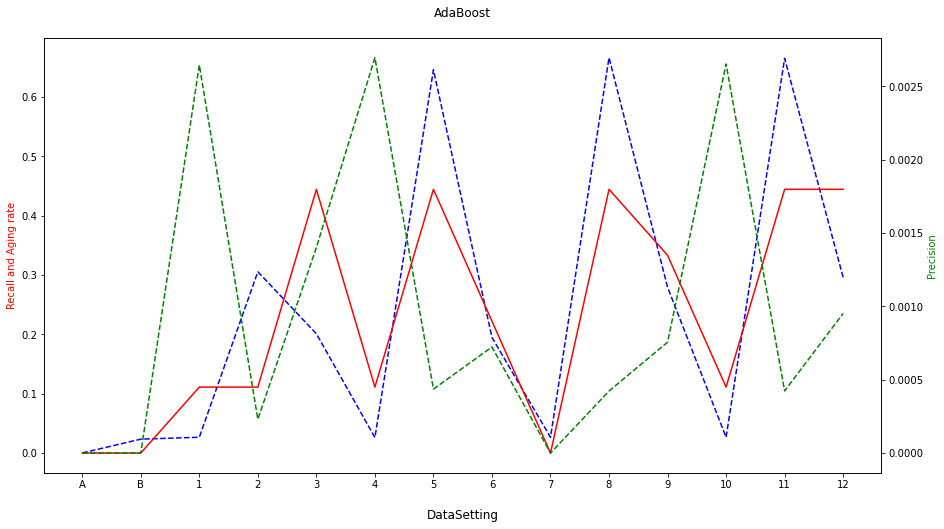

In [37]:
training(DataSet_A)
p,r=cf_matrix(X_train,X_test,Y_train,Y_test,n_E=100,LR=0.7,r=0,infor=0)
df_A=pd.DataFrame([p,r,ar]).T
df_A.index=['DataSettingA']
df_A.columns=['p3','r3','Aging_rate']

training(DataSet_B)
p,r=cf_matrix(X_train,X_test,Y_train,Y_test,n_E=100,LR=0.7,r=0,infor=0)
df_B=pd.DataFrame([p,r,ar]).T
df_B.index=['DataSettingB']
df_B.columns=['p3','r3','Aging_rate']

start = time.time()
S4_AdaBoost(12,n_E=100,LR=0.7)
end = time.time()
print("\n執行時間：%f 秒" % (end - start),'\n')

df_PR_new=df_PR_new.drop(columns=['DataSetting'])
DF=pd.concat([df_PR.iloc[:,1:4],df_PR_new.iloc[:,1:]],axis=1)
DF.insert(9,'Aging_rate',df_PR.iloc[:,4:5])
DF=DF.iloc[:,~DF.columns.duplicated()]
DF=pd.concat([DF,df_A,df_B,DF]).iloc[12:]
DF.insert(0,'DataSetting',np.append(['A','B'],np.arange(1,13)))
DF.insert(11,'Eff',(DF.r3)/(DF.Aging_rate))
DF.insert(1,'BR',(DF.Train_NG)/(DF.Train_OK))
pd.set_option('max_columns',None)
display(color(DF))
Line_Chart(DF,'AdaBoost\n','AdaBoost.jpg')
DF.to_csv('Ada_0.csv')

# Regressor

# 12個資料集的GB值(同adaboost)  維持0或1 / 判定Bad的標準 = 0.5

Types of Bad : [ 0. 14. 60. 16. 20. 30. 13. 47.  8.]
Aging_Rate_prob=0.5 : 0
Bad Detection when threshold=0.5 : []
PR curve :
Precision & Recall: [] []


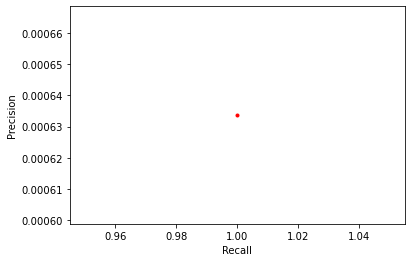

AUC:  0.0006336689431810181 

Types of Bad : [ 0. 14. 60. 16. 20. 30. 13. 47.  8.]
Aging_Rate_prob=0.5 : [0.02316412]
Bad Detection when threshold=0.5 : []
PR curve :
Precision & Recall: [0.] [0.]


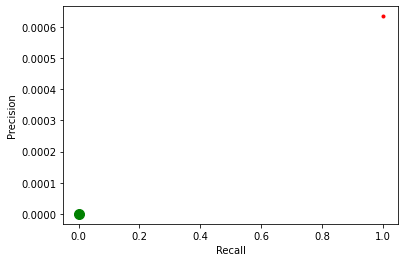

AUC:  0.0006336689431810181 

Model 1 :

Train_1 :
PR curve :
Precision & Recall: [0.98787879] [0.98787879]


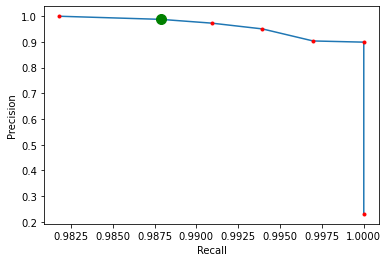

AUC:  0.999270286483981 

Train_2 :
PR curve :
Precision & Recall: [0.72283814] [0.98787879]


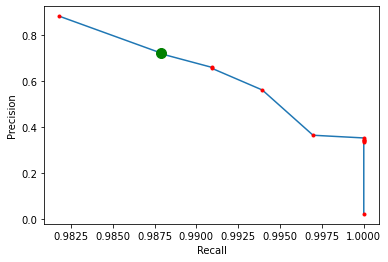

AUC:  0.8780761157021655 

H: [0.00900566] 

Test:
Types of Bad : [16.  0. 14. 60. 20. 30. 13. 47.  8.]
Aging_Rate_prob=0.5 : [0.03133141]
Bad Detection when threshold=0.5 : [16.]
PR curve :
Precision & Recall: [0.00224719] [0.11111111]


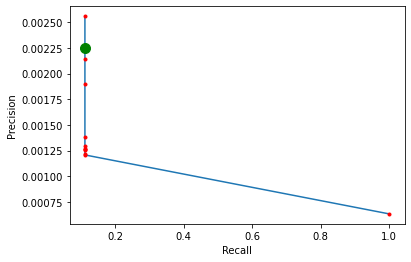

AUC:  0.0011025709337948283 

Model 2 :

Train_1 :
PR curve :
Precision & Recall: [1.] [1.]


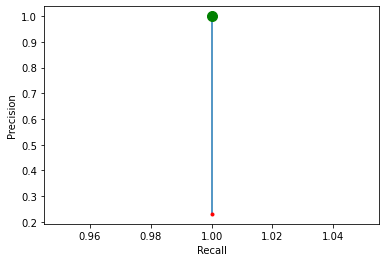

AUC:  1.0 

Train_2 :
PR curve :
Precision & Recall: [0.0806846] [1.]


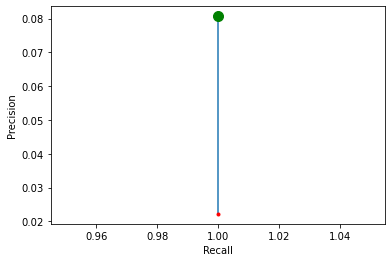

AUC:  0.08068459657701711 

H: [0.27986602] 

Test:
Types of Bad : [16.  0. 14. 60. 20. 30. 13. 47.  8.]
Aging_Rate_prob=0.5 : [0.28346124]
Bad Detection when threshold=0.5 : [16.]
PR curve :
Precision & Recall: [0.00024839] [0.11111111]


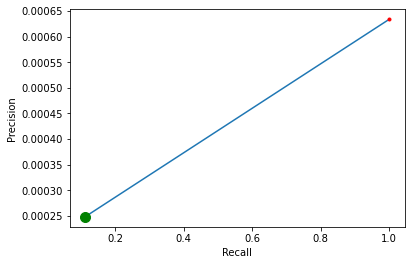

AUC:  0.00041962258268441556 

Model 3 :

Train_1 :
PR curve :
Precision & Recall: [1.] [0.98181818]


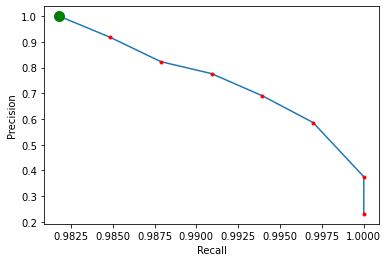

AUC:  0.9954021996934298 

Train_2 :
PR curve :
Precision & Recall: [0.12862247] [0.98181818]


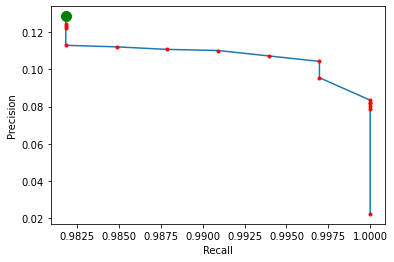

AUC:  0.12821865887456868 

H: [0.16336707] 

Test:
Types of Bad : [16. 20.  8. 14.  0. 60. 30. 13. 47.]
Aging_Rate_prob=0.5 : [0.20826586]
Bad Detection when threshold=0.5 : [ 8. 16. 20.]
PR curve :
Precision & Recall: [0.0010142] [0.33333333]


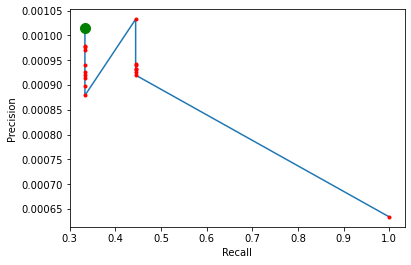

AUC:  0.0008758409237833968 

Model 4 :

Train_1 :
PR curve :
Precision & Recall: [1.] [1.]


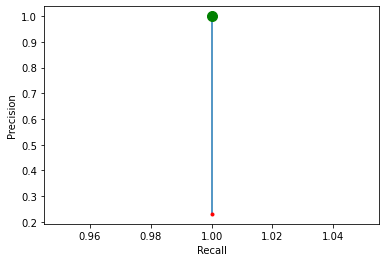

AUC:  1.0 

Train_2 :
PR curve :
Precision & Recall: [0.8443804] [1.]


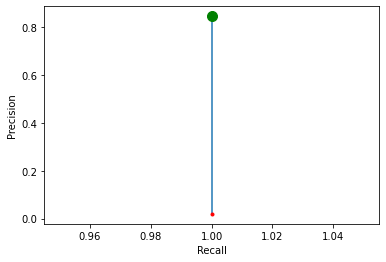

AUC:  0.8443804034582133 

H: [0.0039823] 

Test:
Types of Bad : [16.  0. 14. 60. 20. 30. 13. 47.  8.]
Aging_Rate_prob=0.5 : [0.02844469]
Bad Detection when threshold=0.5 : [16.]
PR curve :
Precision & Recall: [0.00247525] [0.11111111]


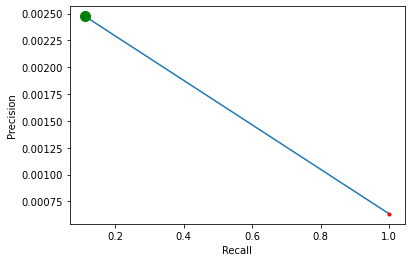

AUC:  0.0016567681551651608 

Model 5 :

Train_1 :
PR curve :
Precision & Recall: [1.] [1.]


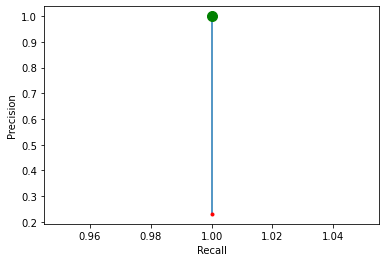

AUC:  1.0 

Train_2 :
PR curve :
Precision & Recall: [0.03870542] [1.]


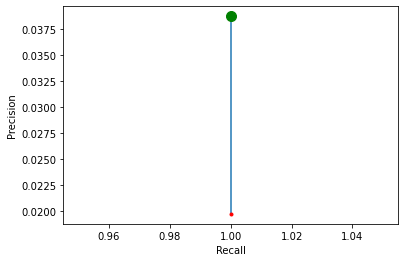

AUC:  0.03870541611624835 

H: [0.53665192] 

Test:
Types of Bad : [ 0. 16. 47. 14. 60. 20. 30. 13.  8.]
Aging_Rate_prob=0.5 : [0.56410617]
Bad Detection when threshold=0.5 : [ 0. 16. 47.]
PR curve :
Precision & Recall: [0.00037444] [0.33333333]


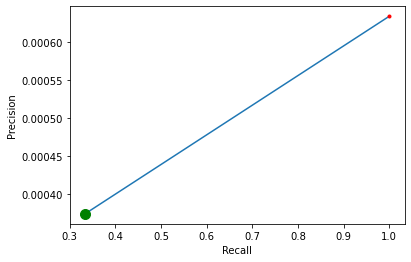

AUC:  0.0004608485427178531 

Model 6 :

Train_1 :
PR curve :
Precision & Recall: [1.] [1.]


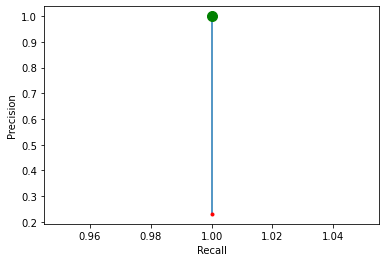

AUC:  1.0 

Train_2 :
PR curve :
Precision & Recall: [0.24036095] [1.]


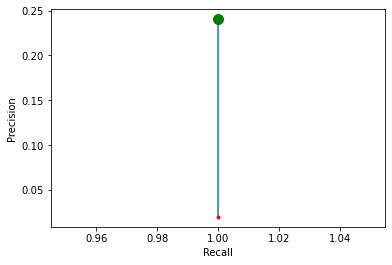

AUC:  0.24036095159967186 

H: [0.06828909] 

Test:
Types of Bad : [16.  0. 14. 60. 20. 30. 13. 47.  8.]
Aging_Rate_prob=0.5 : [0.13391537]
Bad Detection when threshold=0.5 : [16.]
PR curve :
Precision & Recall: [0.00052576] [0.11111111]


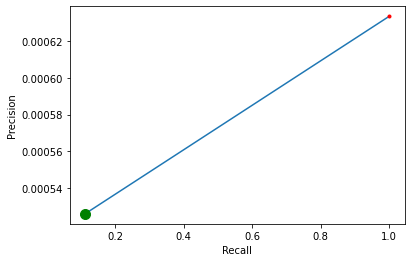

AUC:  0.0005737208388667593 

Model 7 :

Train_1 :
PR curve :
Precision & Recall: [0.99388379] [0.98484848]


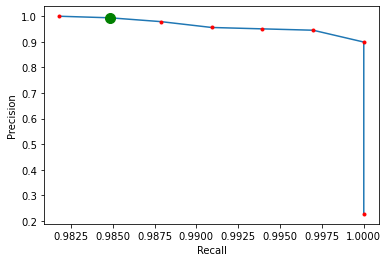

AUC:  0.9993173373911842 

Train_2 :
PR curve :
Precision & Recall: [0.7985258] [0.98484848]


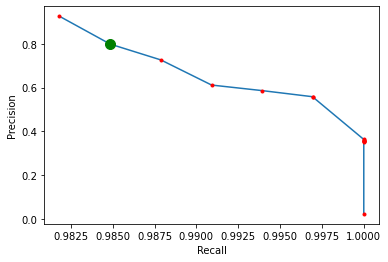

AUC:  0.920769098547024 

H: [0.00596214] 

Test:
Types of Bad : [ 0. 14. 60. 16. 20. 30. 13. 47.  8.]
Aging_Rate_prob=0.5 : [0.0285151]
Bad Detection when threshold=0.5 : []
PR curve :
Precision & Recall: [0.] [0.]


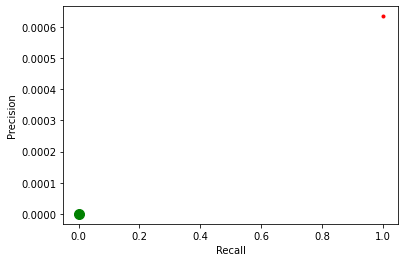

AUC:  0.0006336689431810181 

Model 8 :

Train_1 :
PR curve :
Precision & Recall: [1.] [1.]


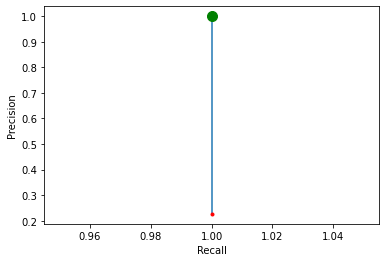

AUC:  1.0 

Train_2 :
PR curve :
Precision & Recall: [0.03744893] [1.]


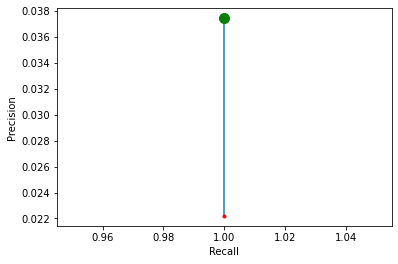

AUC:  0.037448933272809806 

H: [0.63256022] 

Test:
Types of Bad : [ 0. 16. 20. 47. 14. 60. 30. 13.  8.]
Aging_Rate_prob=0.5 : [0.64599028]
Bad Detection when threshold=0.5 : [ 0. 16. 20. 47.]
PR curve :
Precision & Recall: [0.00043597] [0.44444444]


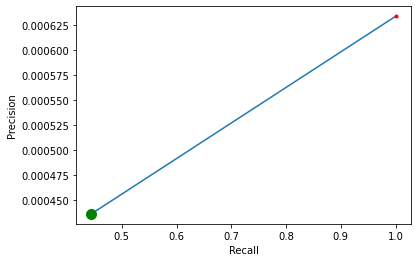

AUC:  0.0004908844248769555 

Model 9 :

Train_1 :
PR curve :
Precision & Recall: [1.] [0.98181818]


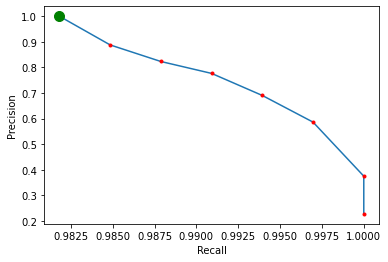

AUC:  0.9953109846814034 

Train_2 :
PR curve :
Precision & Recall: [0.25714286] [0.98181818]


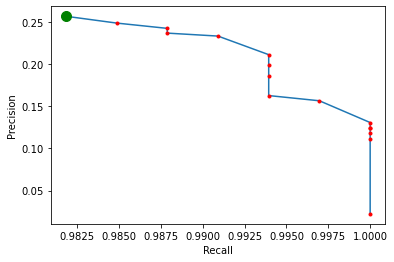

AUC:  0.2562867256485792 

H: [0.06975704] 

Test:
Types of Bad : [16. 14.  0. 60. 20. 30. 13. 47.  8.]
Aging_Rate_prob=0.5 : [0.13546434]
Bad Detection when threshold=0.5 : [16.]
PR curve :
Precision & Recall: [0.00051975] [0.11111111]


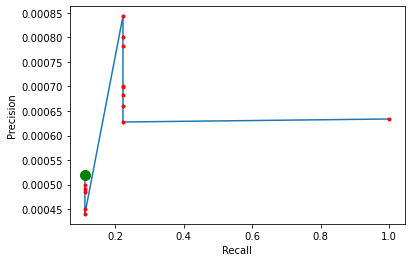

AUC:  0.00061951893021449 

Model 10 :

Train_1 :
PR curve :
Precision & Recall: [0.9702381] [0.98787879]


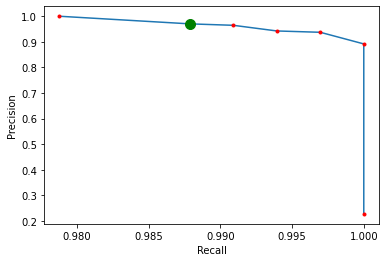

AUC:  0.9991844684220841 

Train_2 :
PR curve :
Precision & Recall: [0.68631579] [0.98787879]


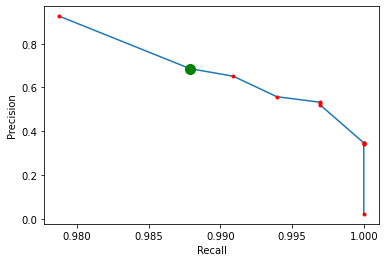

AUC:  0.9200200619847799 

H: [0.01035922] 

Test:
Types of Bad : [16.  0. 14. 60. 20. 30. 13. 47.  8.]
Aging_Rate_prob=0.5 : [0.03062733]
Bad Detection when threshold=0.5 : [16.]
PR curve :
Precision & Recall: [0.00229885] [0.11111111]


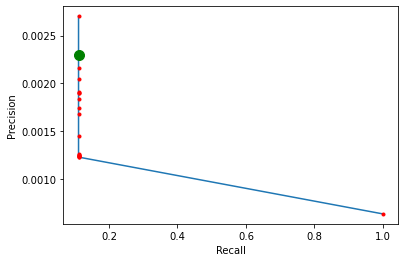

AUC:  0.0011279314877146321 

Model 11 :

Train_1 :
PR curve :
Precision & Recall: [1.] [1.]


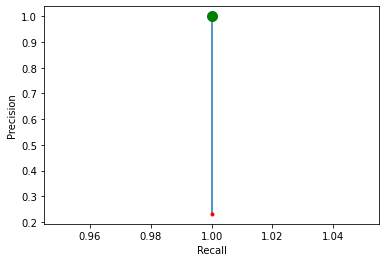

AUC:  1.0 

Train_2 :
PR curve :
Precision & Recall: [0.03582673] [1.]


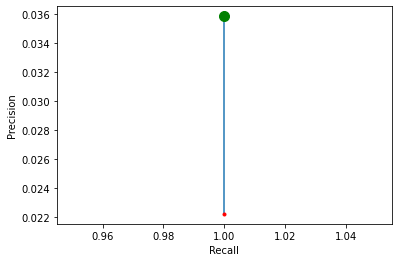

AUC:  0.03582672891108457 

H: [0.66064123] 

Test:
Types of Bad : [ 0. 16. 20. 47. 14. 60. 30. 13.  8.]
Aging_Rate_prob=0.5 : [0.66626769]
Bad Detection when threshold=0.5 : [ 0. 16. 20. 47.]
PR curve :
Precision & Recall: [0.0004227] [0.44444444]


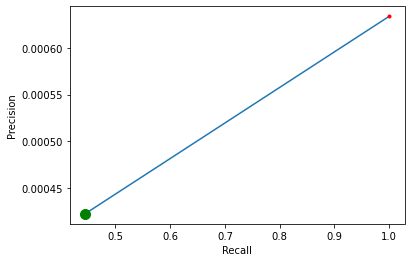

AUC:  0.0004813017133784792 

Model 12 :

Train_1 :
PR curve :
Precision & Recall: [1.] [0.98181818]


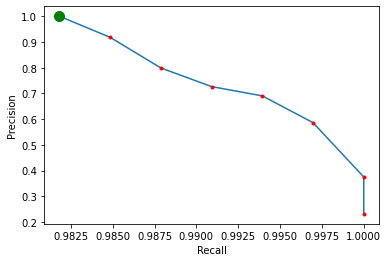

AUC:  0.9951771447268122 

Train_2 :
PR curve :
Precision & Recall: [0.13590604] [0.98181818]


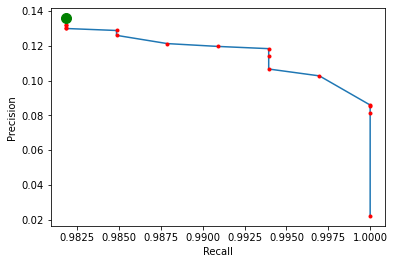

AUC:  0.13553134768184674 

H: [0.1532396] 

Test:
Types of Bad : [16. 20.  8.  0. 14. 60. 30. 13. 47.]
Aging_Rate_prob=0.5 : [0.19925368]
Bad Detection when threshold=0.5 : [ 8. 16. 20.]
PR curve :
Precision & Recall: [0.00106007] [0.33333333]


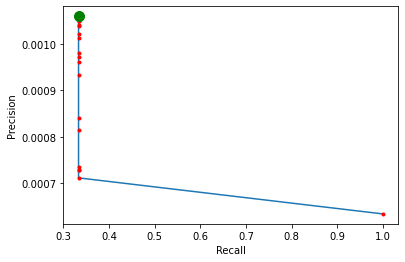

AUC:  0.0008017152758355676 



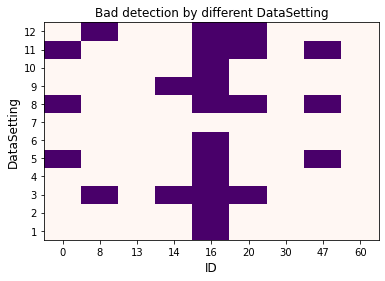

    DataSetting        p1        r1        p2        r2        p3        r3  \
0             1  0.987879  0.987879  0.722838  0.987879  0.002247  0.111111   
1             2  1.000000  1.000000  0.080685  1.000000  0.000248  0.111111   
2             3  1.000000  0.981818  0.128622  0.981818  0.001014  0.333333   
3             4  1.000000  1.000000  0.844380  1.000000  0.002475  0.111111   
4             5  1.000000  1.000000  0.038705  1.000000  0.000374  0.333333   
5             6  1.000000  1.000000  0.240361  1.000000  0.000526  0.111111   
6             7  0.993884  0.984848  0.798526  0.984848  0.000000  0.000000   
7             8  1.000000  1.000000  0.037449  1.000000  0.000436  0.444444   
8             9  1.000000  0.981818  0.257143  0.981818  0.000520  0.111111   
9            10  0.970238  0.987879  0.686316  0.987879  0.002299  0.111111   
10           11  1.000000  1.000000  0.035827  1.000000  0.000423  0.444444   
11           12  1.000000  0.981818  0.135906  0.981

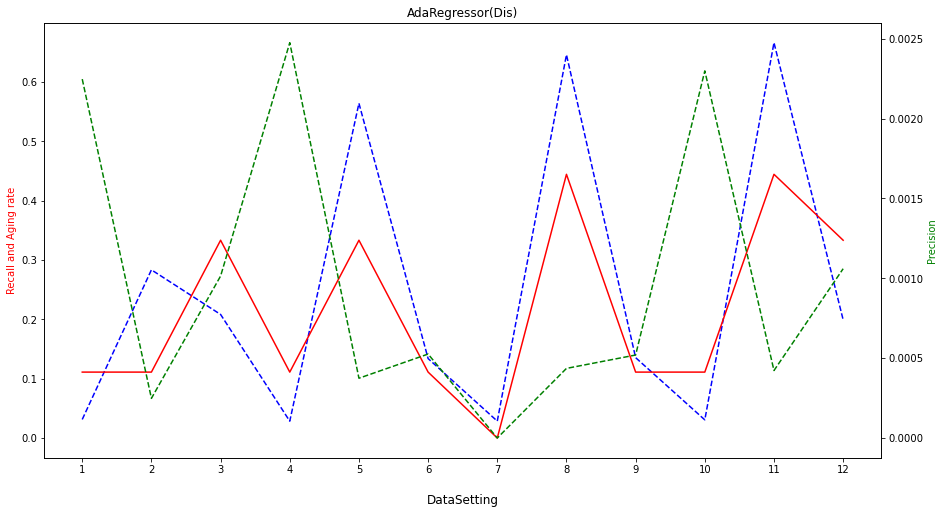

,DataSetting,BR,p1,r1,p2,r2,p3,r3,Aging_rate,Eff,AUC,SRS
DataSettingA,A,nan,nan,nan,nan,nan,0.0000,0.0000,0.0000,nan,0.0006,nan
DataSettingB,B,nan,nan,nan,nan,nan,0.0000,0.0000,0.0232,nan,0.0006,nan
0,1,0.3000,0.9879,0.9879,0.7228,0.9879,0.0022,0.1111,0.0313,3.5463,0.0011,0.0090
1,2,0.2997,1.0000,1.0000,0.0807,1.0000,0.0002,0.1111,0.2835,0.3920,0.0004,0.2799
2,3,0.3000,1.0000,0.9818,0.1286,0.9818,0.0010,0.3333,0.2083,1.6005,0.0009,0.1634
3,4,0.3002,1.0000,1.0000,0.8444,1.0000,0.0025,0.1111,0.0284,3.9062,0.0017,0.0040
4,5,0.3002,1.0000,1.0000,0.0387,1.0000,0.0004,0.3333,0.5641,0.5909,0.0005,0.5367
5,6,0.3002,1.0000,1.0000,0.2404,1.0000,0.0005,0.1111,0.1339,0.8297,0.0006,0.0683
6,7,0.2952,0.9939,0.9848,0.7985,0.9848,0.0000,0.0000,0.0285,0.0000,0.0006,0.0060
7,8,0.2928,1.0000,1.0000,0.0374,1.0000,0.0004,0.4444,0.6460,0.6880,0.0005,0.6326


In [35]:
training(DataSet_A)
Ada_Reg_clf(X_train,X_test,Y_train,Y_test,n_E=100,LR=0.7,r=0,infor=1,prob=0.5)
if Aging_Rate!=0:
    Aging_Rate=np.around(Aging_Rate[0],decimals=5)
df_A=pd.DataFrame([p,r,auc,Aging_Rate]).T
df_A.index=['DataSettingA']
df_A.columns=['p3','r3','AUC','Aging_rate']

training(DataSet_B)
Ada_Reg_clf(X_train,X_test,Y_train,Y_test,n_E=100,LR=0.7,r=0,infor=1,prob=0.5)
df_B=pd.DataFrame([p,r,auc,np.around(Aging_Rate[0],decimals=5)]).T
df_B.index=['DataSettingB']
df_B.columns=['p3','r3','AUC','Aging_rate']

start = time.time()
S4_AdaRegressor_Dis(12,r=0.8,probability=0.5)
end = time.time()
print("執行時間：%f 秒" % (end - start))

Score.insert(8,'Eff',(Score.r3)/(Score.Aging_rate))
Score.insert(1,'BR',DF.BR)
Score=pd.concat([Score,df_A,df_B,Score]).iloc[12:]

Line_Chart_reg(Score,'AdaRegressor(Dis)','AdaRegressor(Dis).jpg')
Score['DataSetting']=(np.append(['A','B'],np.arange(1,13)))
Score.to_csv('Ada_reg_0.csv')
display(color(Score))

# 12個資料集的GB值 轉換成 連續值 0~1區間 / 判定Bad的標準 = 0.5

Model 1 :

Train_1 :
PR curve :
Precision & Recall: [0.42635659] [1.]


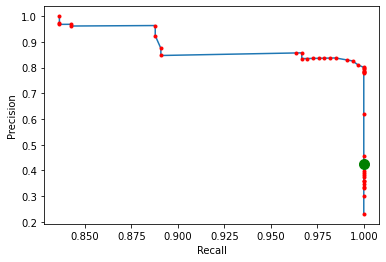

AUC:  0.9809933181938777 

Train_2 :
PR curve :
Precision & Recall: [0.0528169] [1.]


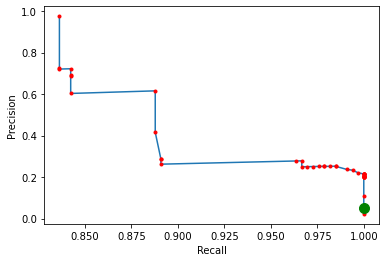

AUC:  0.8773703667653612 

H: [0.40741292] 

Test:
Types of Bad : [16.  0. 47.  8. 14. 60. 20. 30. 13.]
Aging_Rate_prob=0.5 : [0.41843273]
Bad Detection when threshold=0.5 : [ 0. 16. 47.]
PR curve :
Precision & Recall: [0.0005048] [0.33333333]


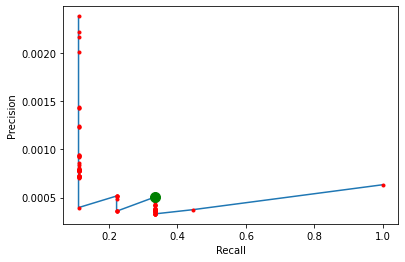

AUC:  0.0006824988536127364 

Model 2 :

Train_1 :
PR curve :
Precision & Recall: [0.69620253] [1.]


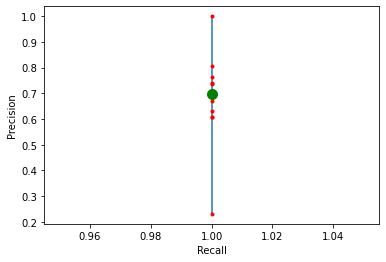

AUC:  1.0 

Train_2 :
PR curve :
Precision & Recall: [0.02999727] [1.]


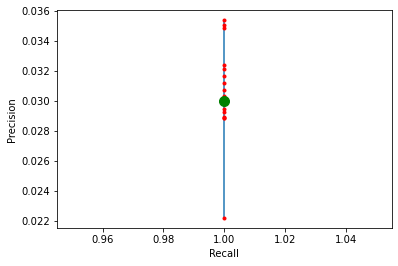

AUC:  0.035392535392535396 

H: [0.78355043] 

Test:
Types of Bad : [ 0. 16. 20. 30. 47.  8. 13. 14. 60.]
Aging_Rate_prob=0.5 : [0.7334366]
Bad Detection when threshold=0.5 : [ 0.  8. 16. 20. 30. 47.]
PR curve :
Precision & Recall: [0.00057598] [0.66666667]


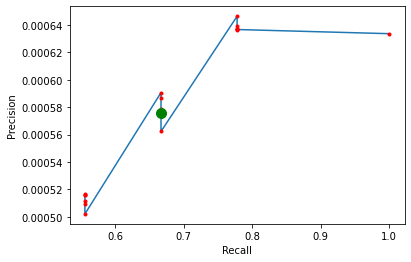

AUC:  0.0005559342662360249 

Model 3 :

Train_1 :
PR curve :
Precision & Recall: [0.24017467] [1.]


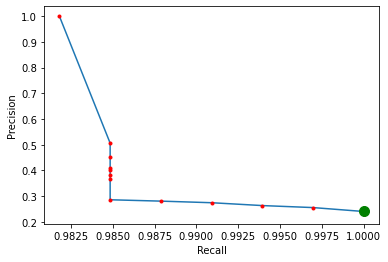

AUC:  0.988150543508059 

Train_2 :
PR curve :
Precision & Recall: [0.0236644] [1.]


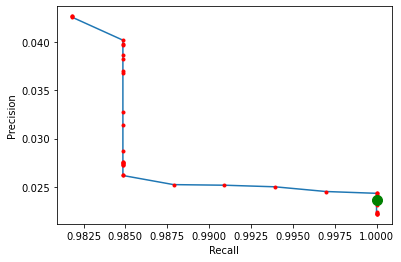

AUC:  0.04239978745332986 

H: [0.93562072] 

Test:
Types of Bad : [ 0. 60. 20. 16. 47. 30. 14.  8. 13.]
Aging_Rate_prob=0.5 : [0.94367387]
Bad Detection when threshold=0.5 : [ 0. 16. 20. 30. 47. 60.]
PR curve :
Precision & Recall: [0.00044766] [0.66666667]


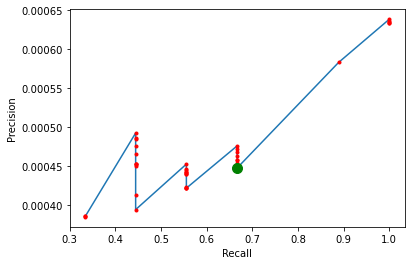

AUC:  0.000456796320231074 

Model 4 :

Train_1 :
PR curve :
Precision & Recall: [0.42773723] [1.]


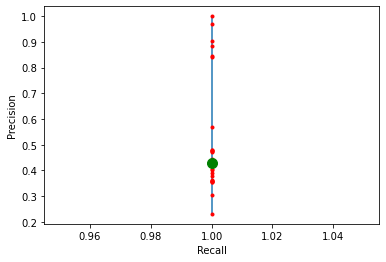

AUC:  1.0 

Train_2 :
PR curve :
Precision & Recall: [0.04758038] [1.]


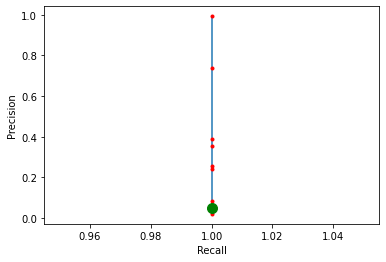

AUC:  0.9932203389830508 

H: [0.40361357] 

Test:
Types of Bad : [16.  0. 47.  8. 14. 60. 20. 30. 13.]
Aging_Rate_prob=0.5 : [0.36971062]
Bad Detection when threshold=0.5 : [ 0. 16. 47.]
PR curve :
Precision & Recall: [0.00057132] [0.33333333]


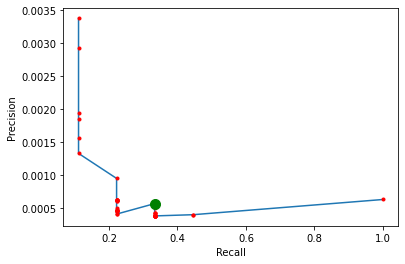

AUC:  0.0008886922140539311 

Model 5 :

Train_1 :
PR curve :
Precision & Recall: [0.68779343] [1.]


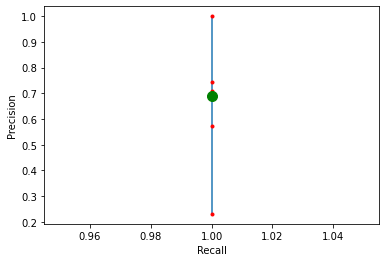

AUC:  1.0 

Train_2 :
PR curve :
Precision & Recall: [0.07726793] [1.]


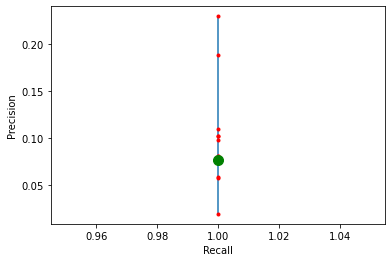

AUC:  0.22962382445141066 

H: [0.24823009] 

Test:
Types of Bad : [16.  8. 47. 13.  0. 14. 60. 20. 30.]
Aging_Rate_prob=0.5 : [0.30894881]
Bad Detection when threshold=0.5 : [ 8. 16. 47.]
PR curve :
Precision & Recall: [0.00068368] [0.33333333]


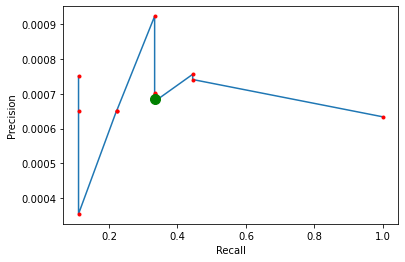

AUC:  0.0006882810795569322 

Model 6 :

Train_1 :
PR curve :
Precision & Recall: [0.29625885] [1.]


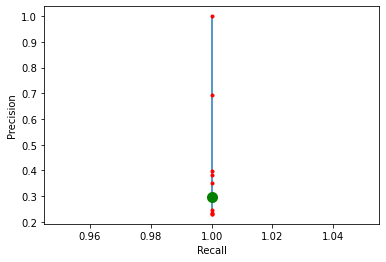

AUC:  1.0 

Train_2 :
PR curve :
Precision & Recall: [0.02951844] [1.]


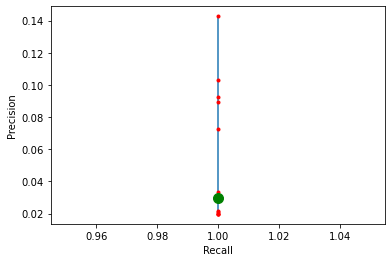

AUC:  0.14264849074975658 

H: [0.6590708] 

Test:
Types of Bad : [16.  0. 60. 20. 30. 14. 13. 47.  8.]
Aging_Rate_prob=0.5 : [0.66704217]
Bad Detection when threshold=0.5 : [ 0. 16. 20. 30. 60.]
PR curve :
Precision & Recall: [0.00052776] [0.55555556]


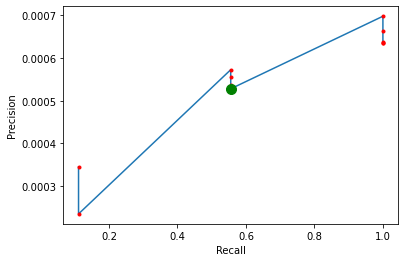

AUC:  0.0004901142759616063 

Model 7 :

Train_1 :
PR curve :
Precision & Recall: [0.42416452] [1.]


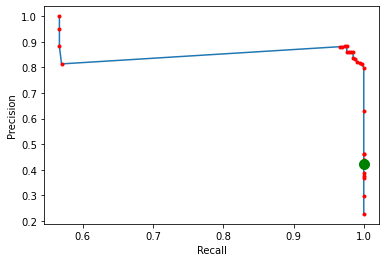

AUC:  0.9339410407499484 

Train_2 :
PR curve :
Precision & Recall: [0.05310589] [1.]


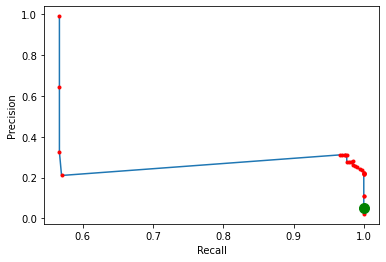

AUC:  0.6740754900445244 

H: [0.40512744] 

Test:
Types of Bad : [16.  0. 47.  8. 14. 60. 20. 30. 13.]
Aging_Rate_prob=0.5 : [0.38639724]
Bad Detection when threshold=0.5 : [ 0. 16. 47.]
PR curve :
Precision & Recall: [0.00054665] [0.33333333]


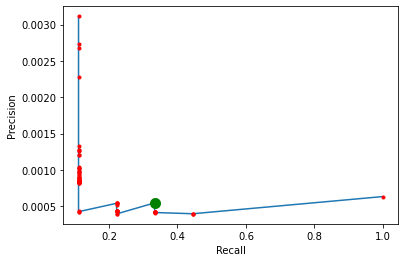

AUC:  0.0007835290357330249 

Model 8 :

Train_1 :
PR curve :
Precision & Recall: [0.6693712] [1.]


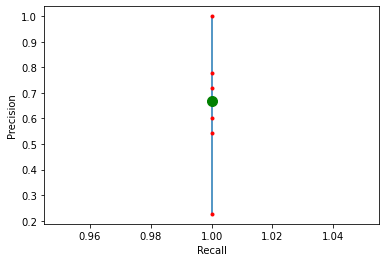

AUC:  1.0 

Train_2 :
PR curve :
Precision & Recall: [0.05149009] [1.]


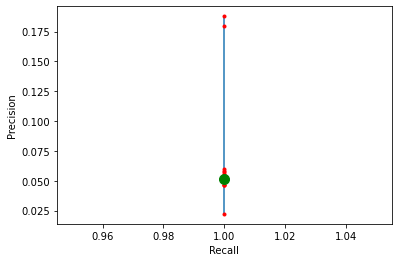

AUC:  0.18782014797951052 

H: [0.44119621] 

Test:
Types of Bad : [16.  0. 47. 14. 60. 20. 30. 13.  8.]
Aging_Rate_prob=0.5 : [0.46990073]
Bad Detection when threshold=0.5 : [ 0. 16.]
PR curve :
Precision & Recall: [0.00029967] [0.22222222]


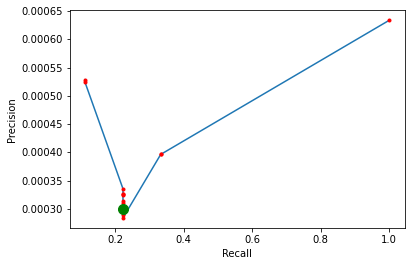

AUC:  0.00048771347626681974 

Model 9 :

Train_1 :
PR curve :
Precision & Recall: [0.28253425] [1.]


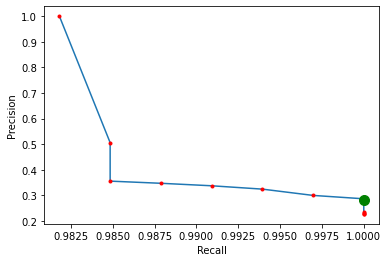

AUC:  0.9890450637587028 

Train_2 :
PR curve :
Precision & Recall: [0.03220455] [1.]


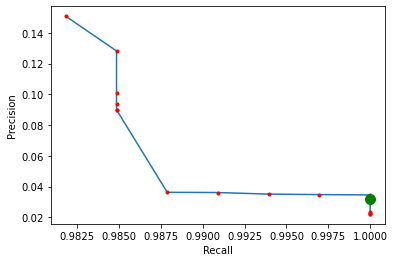

AUC:  0.1491379910194236 

H: [0.67662841] 

Test:
Types of Bad : [47. 16.  0. 60. 20. 30. 14. 13.  8.]
Aging_Rate_prob=0.5 : [0.7030909]
Bad Detection when threshold=0.5 : [ 0. 16. 20. 30. 47. 60.]
PR curve :
Precision & Recall: [0.00060084] [0.66666667]


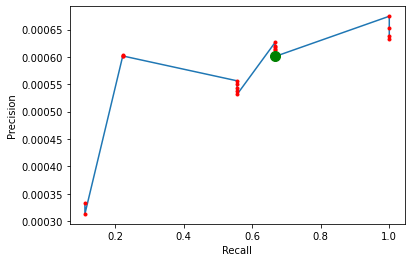

AUC:  0.0005577904647560508 

Model 10 :

Train_1 :
PR curve :
Precision & Recall: [0.42362003] [1.]


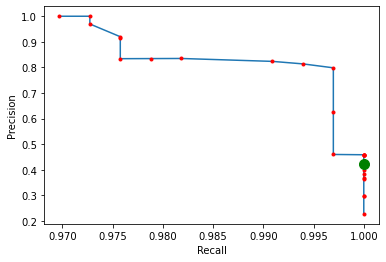

AUC:  0.9945054522353793 

Train_2 :
PR curve :
Precision & Recall: [0.05364109] [1.]


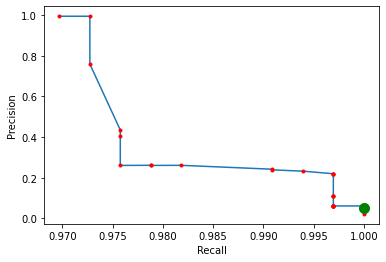

AUC:  0.9739446849354578 

H: [0.40043226] 

Test:
Types of Bad : [16.  0. 47.  8. 14. 60. 20. 30. 13.]
Aging_Rate_prob=0.5 : [0.38498909]
Bad Detection when threshold=0.5 : [ 0. 16.]
PR curve :
Precision & Recall: [0.00036576] [0.22222222]


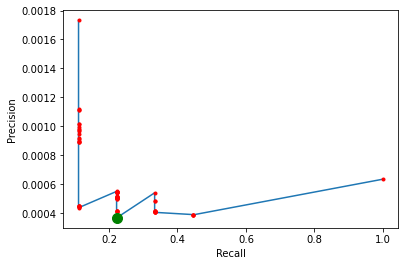

AUC:  0.0006250282904410427 

Model 11 :

Train_1 :
PR curve :
Precision & Recall: [0.67484663] [1.]


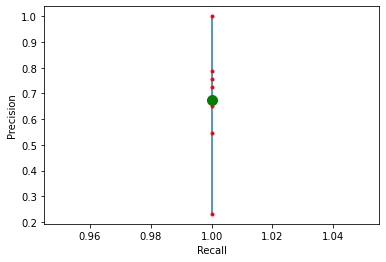

AUC:  1.0 

Train_2 :
PR curve :
Precision & Recall: [0.06021898] [1.]


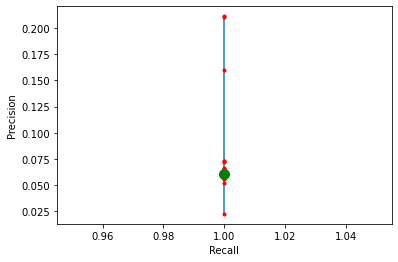

AUC:  0.21153846153846154 

H: [0.37127129] 

Test:
Types of Bad : [16.  0. 13. 14. 60. 20. 30. 47.  8.]
Aging_Rate_prob=0.5 : [0.38189115]
Bad Detection when threshold=0.5 : [ 0. 16.]
PR curve :
Precision & Recall: [0.00036873] [0.22222222]


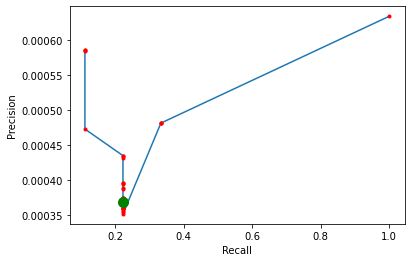

AUC:  0.0005334711748894615 

Model 12 :

Train_1 :
PR curve :
Precision & Recall: [0.28871391] [1.]


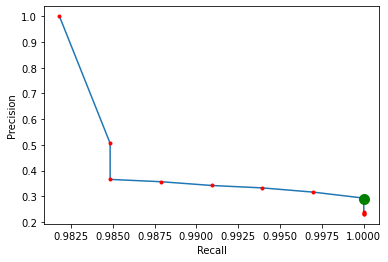

AUC:  0.9891875635621433 

Train_2 :
PR curve :
Precision & Recall: [0.03253475] [1.]


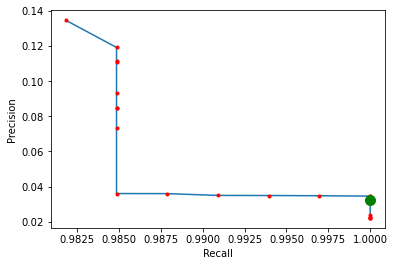

AUC:  0.1330228618857085 

H: [0.66949342] 

Test:
Types of Bad : [16. 47.  0. 60. 20. 30. 14. 13.  8.]
Aging_Rate_prob=0.5 : [0.69076956]
Bad Detection when threshold=0.5 : [ 0. 16. 20. 30. 47. 60.]
PR curve :
Precision & Recall: [0.00061156] [0.66666667]


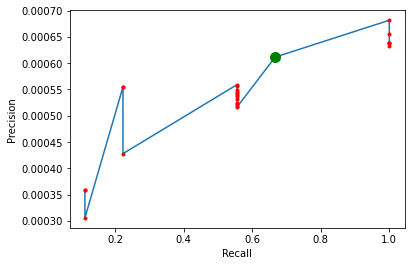

AUC:  0.0005304228270465605 



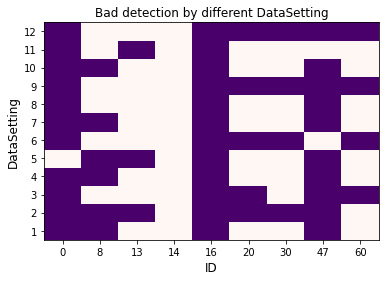

    DataSetting        p1   r1        p2   r2        p3        r3  Aging_rate  \
0             1  0.426357  1.0  0.052817  1.0  0.000505  0.333333    0.418433   
1             2  0.696203  1.0  0.029997  1.0  0.000576  0.666667    0.733437   
2             3  0.240175  1.0  0.023664  1.0  0.000448  0.666667    0.943674   
3             4  0.427737  1.0  0.047580  1.0  0.000571  0.333333    0.369711   
4             5  0.687793  1.0  0.077268  1.0  0.000684  0.333333    0.308949   
5             6  0.296259  1.0  0.029518  1.0  0.000528  0.555556    0.667042   
6             7  0.424165  1.0  0.053106  1.0  0.000547  0.333333    0.386397   
7             8  0.669371  1.0  0.051490  1.0  0.000300  0.222222    0.469901   
8             9  0.282534  1.0  0.032205  1.0  0.000601  0.666667    0.703091   
9            10  0.423620  1.0  0.053641  1.0  0.000366  0.222222    0.384989   
10           11  0.674847  1.0  0.060219  1.0  0.000369  0.222222    0.381891   
11           12  0.288714  1

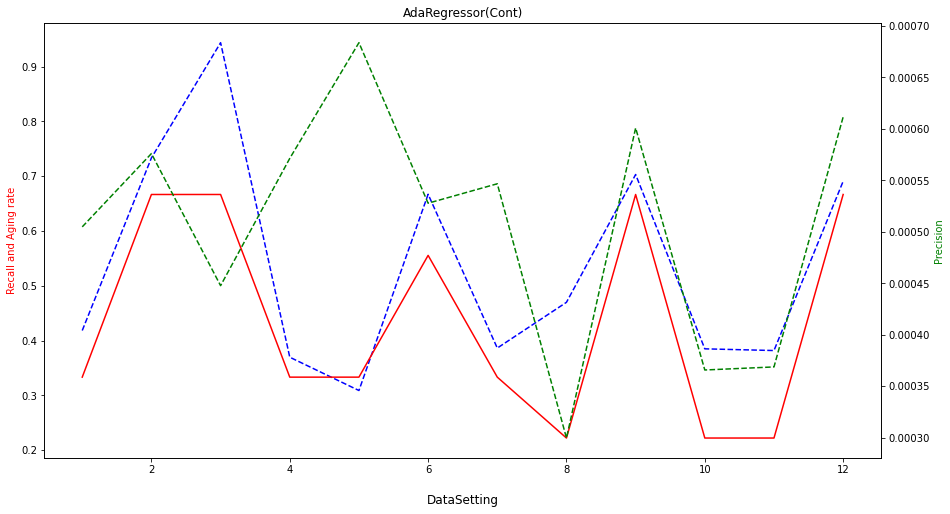

,DataSetting,0_Ratio,p1,r1,p2,r2,p3,r3,Aging_rate,Eff,AUC,SRS
DataSettingA,A,0.3270,nan,nan,nan,nan,0.0000,0.0000,0.0000,nan,0.0006,nan
DataSettingB,B,0.2920,nan,nan,nan,nan,0.0000,0.0000,0.0232,nan,0.0006,nan
0,1,0.2360,0.4264,1.0000,0.0528,1.0000,0.0005,0.3333,0.4184,0.7966,0.0007,0.4074
1,2,0.6200,0.6962,1.0000,0.0300,1.0000,0.0006,0.6667,0.7334,0.9090,0.0006,0.7836
2,3,0.0000,0.2402,1.0000,0.0237,1.0000,0.0004,0.6667,0.9437,0.7065,0.0005,0.9356
3,4,0.2400,0.4277,1.0000,0.0476,1.0000,0.0006,0.3333,0.3697,0.9016,0.0009,0.4036
4,5,0.5960,0.6878,1.0000,0.0773,1.0000,0.0007,0.3333,0.3089,1.0789,0.0007,0.2482
5,6,0.0010,0.2963,1.0000,0.0295,1.0000,0.0005,0.5556,0.6670,0.8329,0.0005,0.6591
6,7,0.2380,0.4242,1.0000,0.0531,1.0000,0.0005,0.3333,0.3864,0.8627,0.0008,0.4051
7,8,0.5820,0.6694,1.0000,0.0515,1.0000,0.0003,0.2222,0.4699,0.4729,0.0005,0.4412


In [36]:
start = time.time()
S4_AdaRegressor(12,r=0.8,probability=0.5)
end = time.time()
print("執行時間：%f 秒" % (end - start))

R_0=[]
DS=pd.read_csv('DataSetting_A_reg.csv')    
r_0=np.around(len(DS[DS.New_GB==0])/len(DS),decimals=3)
R_0=np.append(R_0,r_0)

DS=pd.read_csv('DataSetting_B_reg.csv')    
r_0=np.around(len(DS[DS.New_GB==0])/len(DS),decimals=3)
R_0=np.append(R_0,r_0)

for i in range(1,13):
    DS=pd.read_csv('DataSetting_%s_reg.csv' %i)
    
    r_0=np.around(len(DS[DS.New_GB==0])/len(DS),decimals=3)
    R_0=np.append(R_0,r_0)
    
Score_cont=Score
Score_cont.insert(8,'Eff',(Score_cont.r3)/(Score_cont.Aging_rate))
Score_cont=pd.concat([Score_cont,df_A,df_B,Score_cont]).iloc[12:]
Score_cont.insert(1,'0_Ratio',R_0)
color(Score_cont)
Line_Chart(Score_cont,'AdaRegressor(Cont)','AdaRegressor(Cont).jpg')
Score_cont['DataSetting']=np.append(['A','B'],np.arange(1,13))
Score_cont.to_csv('Ada_reg_cont_0.csv')
display(color(Score_cont))